In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
os.chdir('../')

In [3]:
%%capture
from nutrition_labels.grant_tagger import GrantTagger

In [4]:
data = pd.read_csv('data/processed/training_data.csv')

In [5]:
def run_experiment(sample_not_relevant_range, num_repeats, vectorizer_type,model_type = 'naive_bayes'):
    experiments_results = []
    for n in sample_not_relevant_range:
        average_results_train = None
        average_results_test = None
        for i in range(0, num_repeats):
            # Take the average of 5 runs
            grant_tagger = GrantTagger(
                sample_not_relevant=n,
                ngram_range=(1,2),
                test_size=0.25,
                irrelevant_sample_seed=i,
                split_seed=i,
                vectorizer_type = vectorizer_type,
                model_type = model_type
            )
            X_train, X_test, y_train, y_test = grant_tagger.transform(data)
            grant_tagger.fit(X_train, y_train)
            results_train = grant_tagger.evaluate(X_train, y_train, print_results=False, average='weighted')
            results_test = grant_tagger.evaluate(X_test, y_test, print_results=False, average='weighted')
            if average_results_train: # will be the same for test too
                for key in average_results_train.keys(): # will be the same for test too
                    average_results_train[key] += results_train[key]
                    average_results_test[key] += results_test[key]
            else:
                average_results_train = results_train
                average_results_test = results_test
        average_results_train = {key: value/num_repeats for key, value in average_results_train.items()}
        average_results_test = {key: value/num_repeats for key, value in average_results_test.items()}
        results_dict = {'sample_not_relevant': n}
        for key, value in average_results_train.items():
            results_dict[key+'_train'] = value
        for key, value in average_results_test.items():
            results_dict[key+'_test'] = value
        experiments_results.append(results_dict)
        
    return experiments_results

In [6]:
def plot_results(experiments_results_df):
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=1, ncols=4, figsize=(15, 4))
    experiments_results_df.plot(kind='line', x='sample_not_relevant', y='accuracy_train',ax=ax1, marker='.')
    experiments_results_df.plot(kind='line', x='sample_not_relevant', y='accuracy_test', color='red', ax=ax1, marker='.')
    experiments_results_df.plot(kind='line', x='sample_not_relevant', y='f1_train',ax=ax2, marker='.')
    experiments_results_df.plot(kind='line', x='sample_not_relevant', y='f1_test', color='red', ax=ax2, marker='.')
    experiments_results_df.plot(kind='line', x='sample_not_relevant', y='precision_score_train',ax=ax3, marker='.')
    experiments_results_df.plot(kind='line', x='sample_not_relevant', y='precision_score_test', color='red', ax=ax3, marker='.')
    experiments_results_df.plot(kind='line', x='sample_not_relevant', y='recall_score_train',ax=ax4, marker='.')
    experiments_results_df.plot(kind='line', x='sample_not_relevant', y='recall_score_test', color='red', ax=ax4, marker='.')
    # fig.savefig(f'sample_not_relevant_{num_repeats}reps_{vectorizer_type}.png')
    # plt.close(fig)
    plt.show()

In [7]:
count_experiments_results = run_experiment(
    range(40, 1000, 40), num_repeats=10, vectorizer_type='count'
)

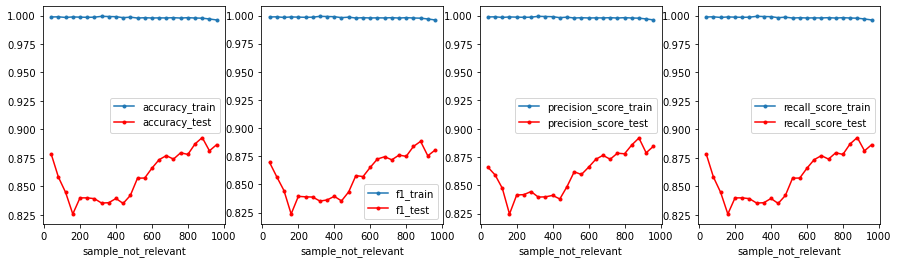

In [8]:
experiments_results_df = pd.DataFrame(count_experiments_results)
plot_results(experiments_results_df)

In [9]:
tfidf_experiments_results = run_experiment(
    range(40, 600, 40), num_repeats=10, vectorizer_type='tfidf'
)

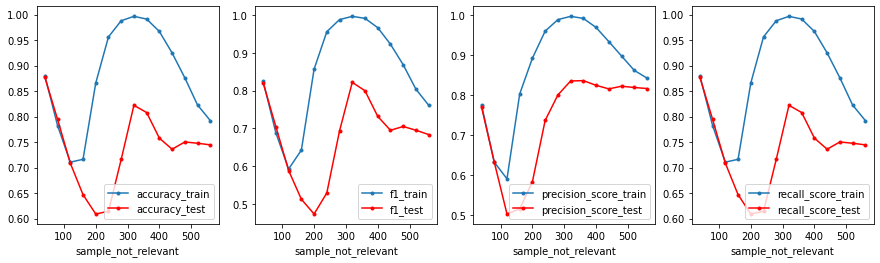

In [10]:
experiments_results_df = pd.DataFrame(tfidf_experiments_results)
plot_results(experiments_results_df)

In [11]:
print(len(data.loc[data['Relevance code'] == 1]))
print(len(data.loc[data['Relevance code'] == 0]))

292
989


## Explore all the results of those with good parameters

In [12]:
def test_setting(data, vectorizer_type, model_type, n):
    i = 4
    grant_tagger = GrantTagger(
                sample_not_relevant=n,
                ngram_range=(1,2),
                test_size=0.25,
                irrelevant_sample_seed=i,
                split_seed=i,
                vectorizer_type = vectorizer_type
                )
    X_train, X_test, y_train, y_test = grant_tagger.transform(data)
    grant_tagger.fit(X_train, y_train)
    results_train = grant_tagger.evaluate(X_train, y_train, average='weighted')
    results_test = grant_tagger.evaluate(X_test, y_test, average='weighted')

In [13]:
test_setting(data, 'tfidf', 40)

{'accuracy': 0.8755020080321285, 'f1': 0.8173851723811736, 'precision_score': 0.7665037660682892, 'recall_score': 0.8755020080321285}
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.88      1.00      0.93       218

    accuracy                           0.88       249
   macro avg       0.44      0.50      0.47       249
weighted avg       0.77      0.88      0.82       249

              predicted tag 0  predicted tag 1
actual tag 0                0               31
actual tag 1                0              218
{'accuracy': 0.891566265060241, 'f1': 0.8404573708848132, 'precision_score': 0.7948904049934679, 'recall_score': 0.891566265060241}
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.89      1.00      0.94        74

    accuracy                           0.89        83
   macro avg       0.45      0.50      0.47     

c:\users\nonie\documents\wellcome\nutrition-labels\venv\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\nonie\documents\wellcome\nutrition-labels\venv\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
test_setting(data, 'tfidf', 320)

{'accuracy': 0.9978213507625272, 'f1': 0.9978211851054627, 'precision_score': 0.99783050475092, 'recall_score': 0.9978213507625272}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       237
           1       1.00      1.00      1.00       222

    accuracy                           1.00       459
   macro avg       1.00      1.00      1.00       459
weighted avg       1.00      1.00      1.00       459

              predicted tag 0  predicted tag 1
actual tag 0              237                0
actual tag 1                1              221
{'accuracy': 0.869281045751634, 'f1': 0.8693480582025475, 'precision_score': 0.880166059324222, 'recall_score': 0.869281045751634}
              precision    recall  f1-score   support

           0       0.94      0.81      0.87        83
           1       0.80      0.94      0.87        70

    accuracy                           0.87       153
   macro avg       0.87      0.88      0.87       1

In [15]:
test_setting(data, 'count', 40)

{'accuracy': 1.0, 'f1': 1.0, 'precision_score': 1.0, 'recall_score': 1.0}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        31
           1       1.00      1.00      1.00       218

    accuracy                           1.00       249
   macro avg       1.00      1.00      1.00       249
weighted avg       1.00      1.00      1.00       249

              predicted tag 0  predicted tag 1
actual tag 0               31                0
actual tag 1                0              218
{'accuracy': 0.8554216867469879, 'f1': 0.8220935690815209, 'precision_score': 0.7912650602409638, 'recall_score': 0.8554216867469879}
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.89      0.96      0.92        74

    accuracy                           0.86        83
   macro avg       0.44      0.48      0.46        83
weighted avg       0.79      0.86      0.82        8

In [16]:
test_setting(data, 'count', 880)

{'accuracy': 0.9965870307167235, 'f1': 0.9965790712363085, 'precision_score': 0.9966024507586662, 'recall_score': 0.9965870307167235}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       661
           1       1.00      0.99      0.99       218

    accuracy                           1.00       879
   macro avg       1.00      0.99      1.00       879
weighted avg       1.00      1.00      1.00       879

              predicted tag 0  predicted tag 1
actual tag 0              661                0
actual tag 1                3              215
{'accuracy': 0.8907849829351536, 'f1': 0.8860903846846023, 'precision_score': 0.8888298498343595, 'recall_score': 0.8907849829351536}
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       219
           1       0.86      0.68      0.76        74

    accuracy                           0.89       293
   macro avg       0.88      0.82      0.84   

## Testing Bert Vectorizer


Bert and Naive Bayes model


In [17]:
%%capture
bert_bayes_experiments_results = run_experiment(
    range(40, 600, 80), num_repeats=5, vectorizer_type='bert'
)


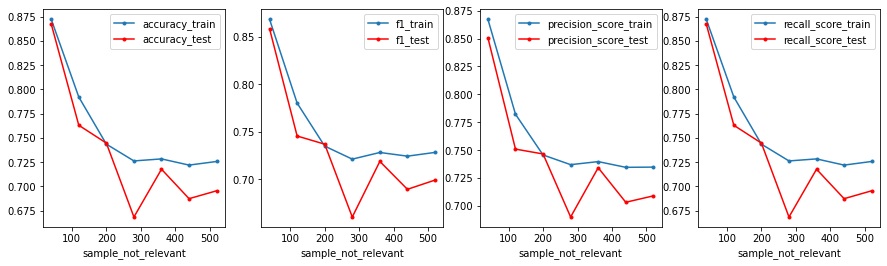

In [18]:
experiments_results_df = pd.DataFrame(bert_bayes_experiments_results)
plot_results(experiments_results_df)

Bert and SVM model


In [19]:
%%capture
bert_svm_experiments_results = run_experiment(
    range(40, 600, 80), num_repeats=5, vectorizer_type='bert', model_type='SVM'
)


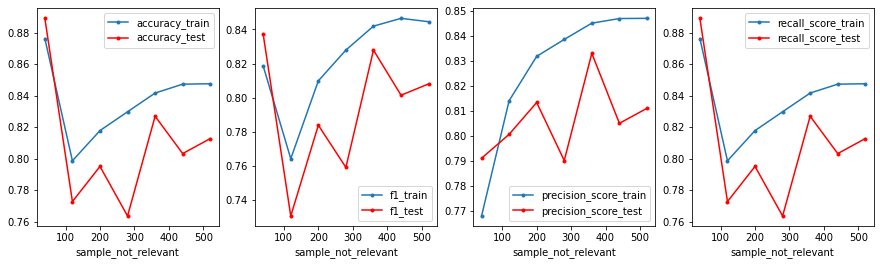

In [20]:
experiments_results_df = pd.DataFrame(bert_svm_experiments_results)
plot_results(experiments_results_df)

Bert and Logistic regression model


In [21]:
%%capture
bert_logreg_experiments_results = run_experiment(
    range(40, 600, 80), num_repeats=5, vectorizer_type='bert', model_type='log_reg'
)


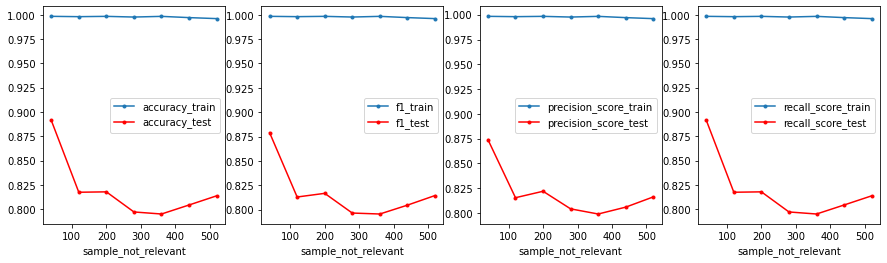

In [22]:
experiments_results_df = pd.DataFrame(bert_logreg_experiments_results)
plot_results(experiments_results_df)